# Import the Necessary Libraries

In [1]:
# Data and Plotting
import pandas as pd
import numpy as np
import plotly.express as px
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

# Data encoding and Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Dimensionality Reduction and Clustering Algorithms
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

from sklearn.utils.class_weight import compute_sample_weight

# Data spliting and Cross Validation and Performance Metrics
from sklearn.model_selection import train_test_split as tts, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import  make_scorer,  precision_score, accuracy_score

# models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier as FNN

from collections import defaultdict as dd
from sklearn.utils import resample

%matplotlib notebook

# Load the Dataset

In [2]:
data = pd.read_csv("Thyroid_Diff.csv")

X = data.drop("Recurred", axis=1)
y = data["Recurred"]
y = y.map({"No":0,"Yes":1})

X_train, X_test, y_train, y_test = tts(X, y, 
                                       train_size=.75, 
                                       random_state=321
                                      )
y_train.value_counts()

Recurred
0    210
1     77
Name: count, dtype: int64

# Define the Data Preprocessing Encoders

In [3]:
# Define preprocessor
num_features = list(X.columns[:1])
cat_features = list(X.columns[1:])

# Define the numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ("scaler", MinMaxScaler())
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
])

# Define your ColumnTransformer (preprocessor)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder="passthrough",
)

# Compute sample weights based on class imbalance
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Plot Confusion Matrices for PCA-Based Classification Pipelines

<IPython.core.display.Javascript object>


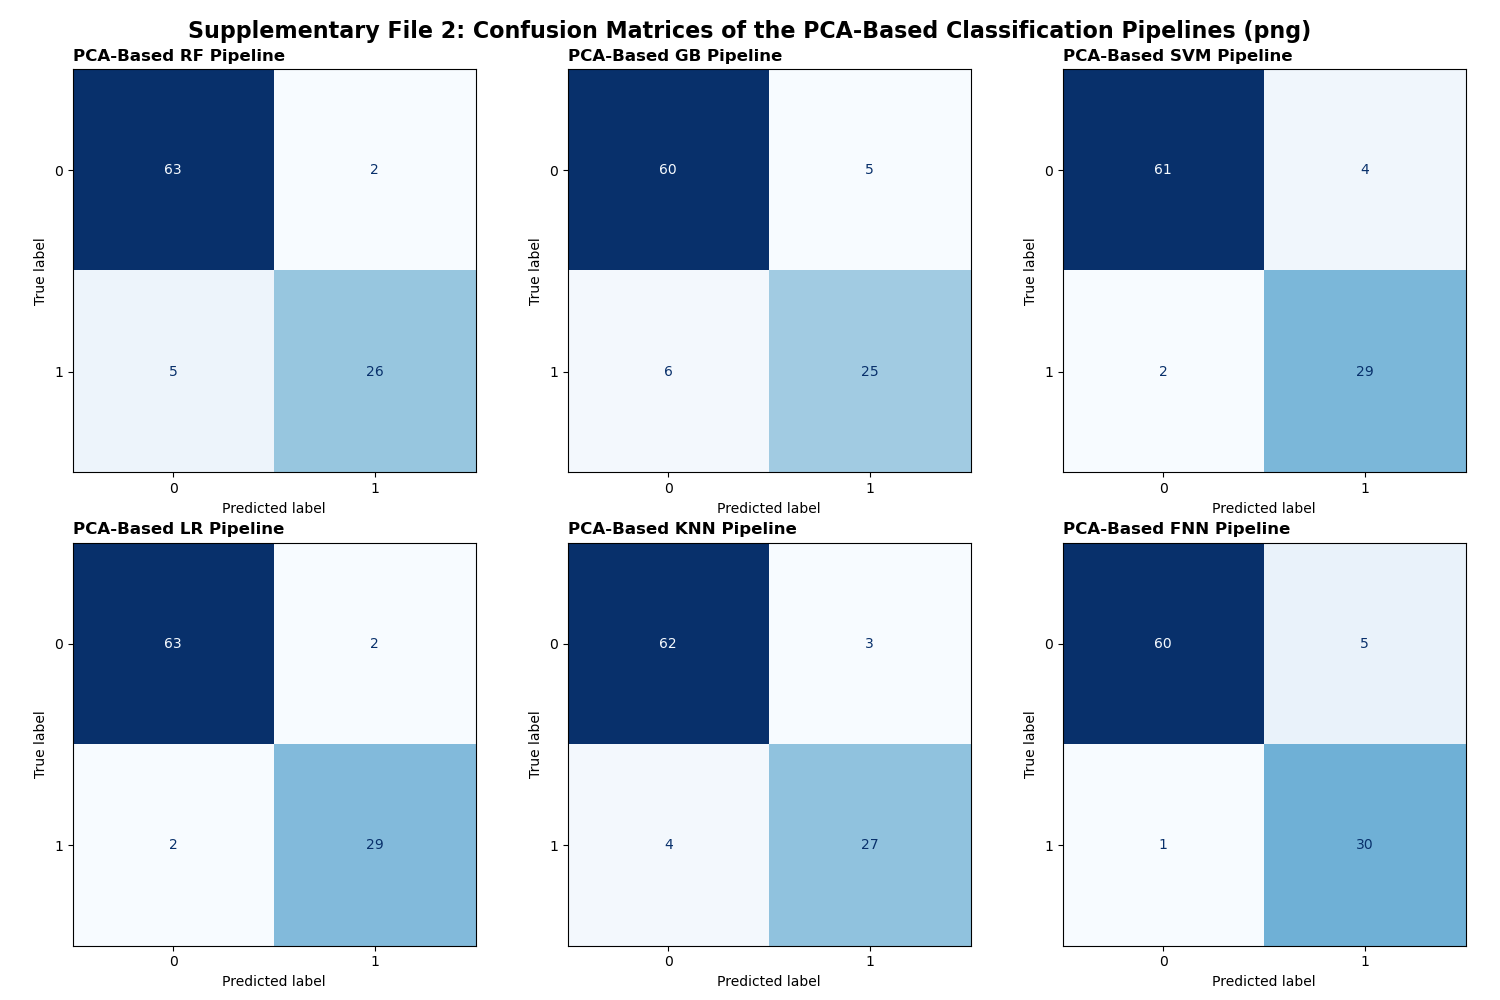

In [4]:
# Define titles for plotting
titles = {
    "RF": "PCA-Based RF Pipeline",
    "GB": "PCA-Based GB Pipeline",
    "SVM": "PCA-Based SVM Pipeline",
    "LR": "PCA-Based LR Pipeline",
    "KNN": "PCA-Based KNN Pipeline",
    "FNN": "PCA-Based FNN Pipeline"
}

# Define models
models_pca = {
    "RF": RFC(criterion='entropy', max_depth=None, max_features='log2', min_samples_leaf=4, min_samples_split=6, 
              n_estimators=403),
    "GB": GBC(criterion='friedman_mse', learning_rate=0.35, loss='exponential', max_depth=6, n_estimators=150, tol=1e-12),
    "SVM": SVC(probability=True, C=0.1, kernel='sigmoid', tol=0.001),
    "LR": LR(C=0.36, penalty='l1', solver='liblinear'),
    "KNN": KNN(n_neighbors=17, p=2, weights='distance'),
    "FNN": FNN(activation='relu', alpha=0.5, early_stopping=True, hidden_layer_sizes=(300,), learning_rate='adaptive', 
               max_iter=10000, solver='lbfgs', tol=1e-05),
}

# Create pipelines with PCA
pipelines = {
    name: Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("dim_red", PCA(n_components=5)),
        ("clf", model)
    ])
    for name, model in models_pca.items()
}

# Plot setup
n_models = len(pipelines)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Fit and display confusion matrix for each model
for ax, (name, pipeline) in zip(axes, pipelines.items()):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        ax=ax,
        colorbar=False,
        cmap="Blues"
    )
    ax.set_title(titles[name], fontsize=12, loc="left", fontweight="bold")

# Remove any empty subplots
for i in range(len(pipelines), len(axes)):
    fig.delaxes(axes[i])
    
plt.suptitle("Supplementary File 2: Confusion Matrices of the PCA-Based Classification Pipelines (png)", 
          fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig("../results/Supplementary File 2.png", dpi=1200)
plt.show()


# Plot Confusion Matrices for t-SVD-Based Classification Pipelines

<IPython.core.display.Javascript object>


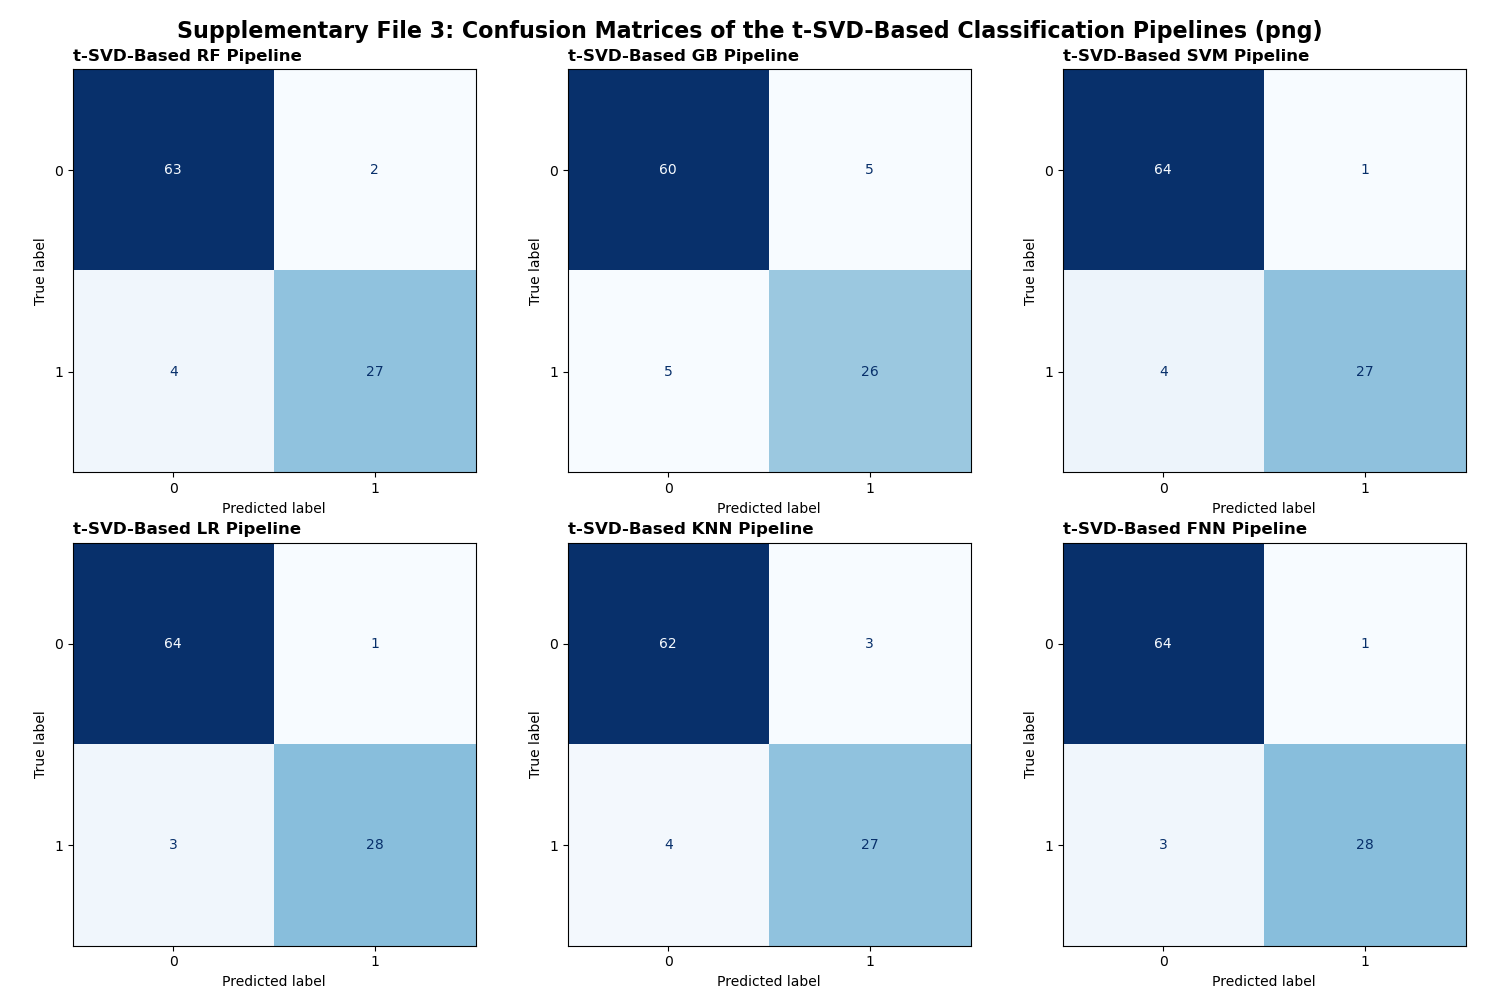

In [5]:
# Define titles for plotting
titles = {
    "RF": "t-SVD-Based RF Pipeline",
    "GB": "t-SVD-Based GB Pipeline",
    "SVM": "t-SVD-Based SVM Pipeline",
    "LR": "t-SVD-Based LR Pipeline",
    "KNN": "t-SVD-Based KNN Pipeline",
    "FNN": "t-SVD-Based FNN Pipeline"
}

# Define models
models_tsvd = {
    "RF": RFC(criterion='entropy', max_depth=None, max_features='log2', 
              min_samples_leaf=3, min_samples_split=6, n_estimators=400),
    "GB": GBC(criterion='squared_error', learning_rate=0.3, loss= 'log_loss', 
              max_depth=4, n_estimators=125, tol=1e-10),
    "SVM": SVC(probability=True, C=0.25, kernel='sigmoid', tol=0.01),
    "LR": LR(C=0.1, max_iter=5000, penalty='l2', solver='liblinear', tol=0.001),
    "KNN": KNN(n_neighbors=18, p=4, weights='distance'),
    "FNN": FNN(activation='identity', alpha=1.0, early_stopping=True, hidden_layer_sizes=(125, 155), 
               learning_rate='constant', max_iter=15000, solver='adam', tol=0.001),
}

# Create pipelines with PCA
pipelines = {
    name: Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("dim_red", TruncatedSVD(n_components=5)),
        ("clf", model)
    ])
    for name, model in models_tsvd.items()
}

# Plot setup
n_models = len(pipelines)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Fit and display confusion matrix for each model
for ax, (name, pipeline) in zip(axes, pipelines.items()):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        ax=ax,
        colorbar=False,
        cmap="Blues"
    )
    ax.set_title(titles[name], fontsize=12, loc="left", fontweight="bold")

# Remove any empty subplots
for i in range(len(pipelines), len(axes)):
    fig.delaxes(axes[i])
    
fig.suptitle("Supplementary File 3: Confusion Matrices of the t-SVD-Based Classification Pipelines (png)", 
          fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig("../results/Supplementary File 3.png", dpi=1200)
plt.show()